# Machine learning 

#### Importing the ML feeding table

In [27]:
from google.cloud import bigquery
import pandas as pd
from dotenv import load_dotenv
import os
from sklearn.cluster import KMeans
import numpy as np4
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Now you can use the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")


# Create a BigQuery client
client = bigquery.Client()

# Your BigQuery query
query = """
SELECT * FROM `big-mamma-project.ML_tables.ML_table_6`
"""

# Run the query and convert it to a pandas dataframe
ml = client.query(query,location="EU").to_dataframe()

# Now df is a pandas DataFrame containing the results of the query
ml.drop(columns="order_id",inplace=True)
ml.head(10)

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
0,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,1,<NA>,<NA>,...,3,36.53,<NA>,6.0,6.0,6.0,11.0,1,<NA>,<NA>
1,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,29.04,<NA>,4.0,3.0,0.0,7.0,1,<NA>,<NA>
2,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,30.87,<NA>,3.0,3.0,1.0,4.0,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,1,<NA>,<NA>,...,5,48.31,<NA>,2.0,4.0,2.0,3.0,<NA>,<NA>,<NA>
4,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,30.91,<NA>,2.0,3.0,0.0,7.0,<NA>,<NA>,<NA>
5,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,1,<NA>,...,2,67.58,1,3.0,3.0,0.0,7.0,<NA>,<NA>,<NA>
6,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,42.52,<NA>,3.0,6.0,4.0,9.0,1,<NA>,<NA>
7,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,13,52.31,1,0.0,0.0,0.0,19.0,<NA>,<NA>,<NA>
8,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,27.32,<NA>,2.0,1.0,0.0,3.0,<NA>,<NA>,<NA>
9,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,36.66,<NA>,2.0,0.0,1.0,1.0,<NA>,<NA>,<NA>


## DF preparation


#### Finding NAs

In [28]:
#Displaying NAs count per column
ml.isnull().sum()

Sunday                   623700
Monday                   646027
Tuesday                  648027
Wednesday                643389
Thursday                 636937
Friday                   627399
Saturday                 611053
card_payment             617871
invoice_payment          205716
cash_payment             714537
DINNER                   327557
LUNCH                    475056
AFTERNOON                687820
actual_duration               0
covers                        0
revenue_per_cover             0
high_spender             622750
total_main_items          24636
total_starters_items      24636
total_desserts_items      24636
total_beverages_items     24636
total_visits              63503
total_cancellations      738977
total_noshows            739189
dtype: int64

In [29]:
ml.dtypes

Sunday                     Int64
Monday                     Int64
Tuesday                    Int64
Wednesday                  Int64
Thursday                   Int64
Friday                     Int64
Saturday                   Int64
card_payment               Int64
invoice_payment            Int64
cash_payment               Int64
DINNER                     Int64
LUNCH                      Int64
AFTERNOON                  Int64
actual_duration            Int64
covers                     Int64
revenue_per_cover        float64
high_spender               Int64
total_main_items         float64
total_starters_items     float64
total_desserts_items     float64
total_beverages_items    float64
total_visits               Int64
total_cancellations        Int64
total_noshows              Int64
dtype: object

#### Fill NAs with 0

In [30]:
# Fill missing values with the mean of each column
ml = ml.fillna(0)
ml.isnull().sum()

Sunday                   0
Monday                   0
Tuesday                  0
Wednesday                0
Thursday                 0
Friday                   0
Saturday                 0
card_payment             0
invoice_payment          0
cash_payment             0
DINNER                   0
LUNCH                    0
AFTERNOON                0
actual_duration          0
covers                   0
revenue_per_cover        0
high_spender             0
total_main_items         0
total_starters_items     0
total_desserts_items     0
total_beverages_items    0
total_visits             0
total_cancellations      0
total_noshows            0
dtype: int64

#### Removing outliers

In [31]:
import pandas as pd
from scipy import stats


# Select numerical columns only 
numerical_columns = ml.select_dtypes(include=[np.number]).columns

# Calculate Z-scores for each numerical column
z_scores = np.abs((ml[numerical_columns] - ml[numerical_columns].mean()) / ml[numerical_columns].std())

# Define a threshold for outliers (e.g., Z-score > 3, meaning values beyond 3 standard deviations)
threshold = 3

# Create a boolean mask for outliers
outlier_mask = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
ml_no_outliers = ml[~outlier_mask]

# Keep only the outliers
ml_outliers_only = ml[outlier_mask]


In [32]:
ml_outliers_only.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
count,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,...,165217.0,165217.000000,165217.0,165217.000000,165217.000000,165217.000000,165217.000000,165217.0,165217.0,165217.0
mean,0.159124,0.119031,0.116296,0.124176,0.139471,0.162169,0.179733,0.174474,0.56171,0.15062,...,18.260936,42.126267,0.211728,2.954993,1.976177,1.328495,4.956076,0.615639,0.002693,0.00141
std,0.365793,0.323826,0.32058,0.329783,0.346439,0.368606,0.383966,0.379517,0.496179,0.357679,...,3621.320308,43.192930,0.408534,2.791557,2.466540,2.077024,5.613131,0.486445,0.051828,0.037527
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,26.110000,0.0,1.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,34.980000,0.0,2.000000,1.000000,1.000000,3.000000,1.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,47.020000,0.0,4.000000,3.000000,2.000000,6.000000,1.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,999999.0,2007.330000,1.0,67.000000,71.000000,44.000000,304.000000,1.0,1.0,1.0


In [33]:
ml=ml[~outlier_mask]

#### Correlation check and heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

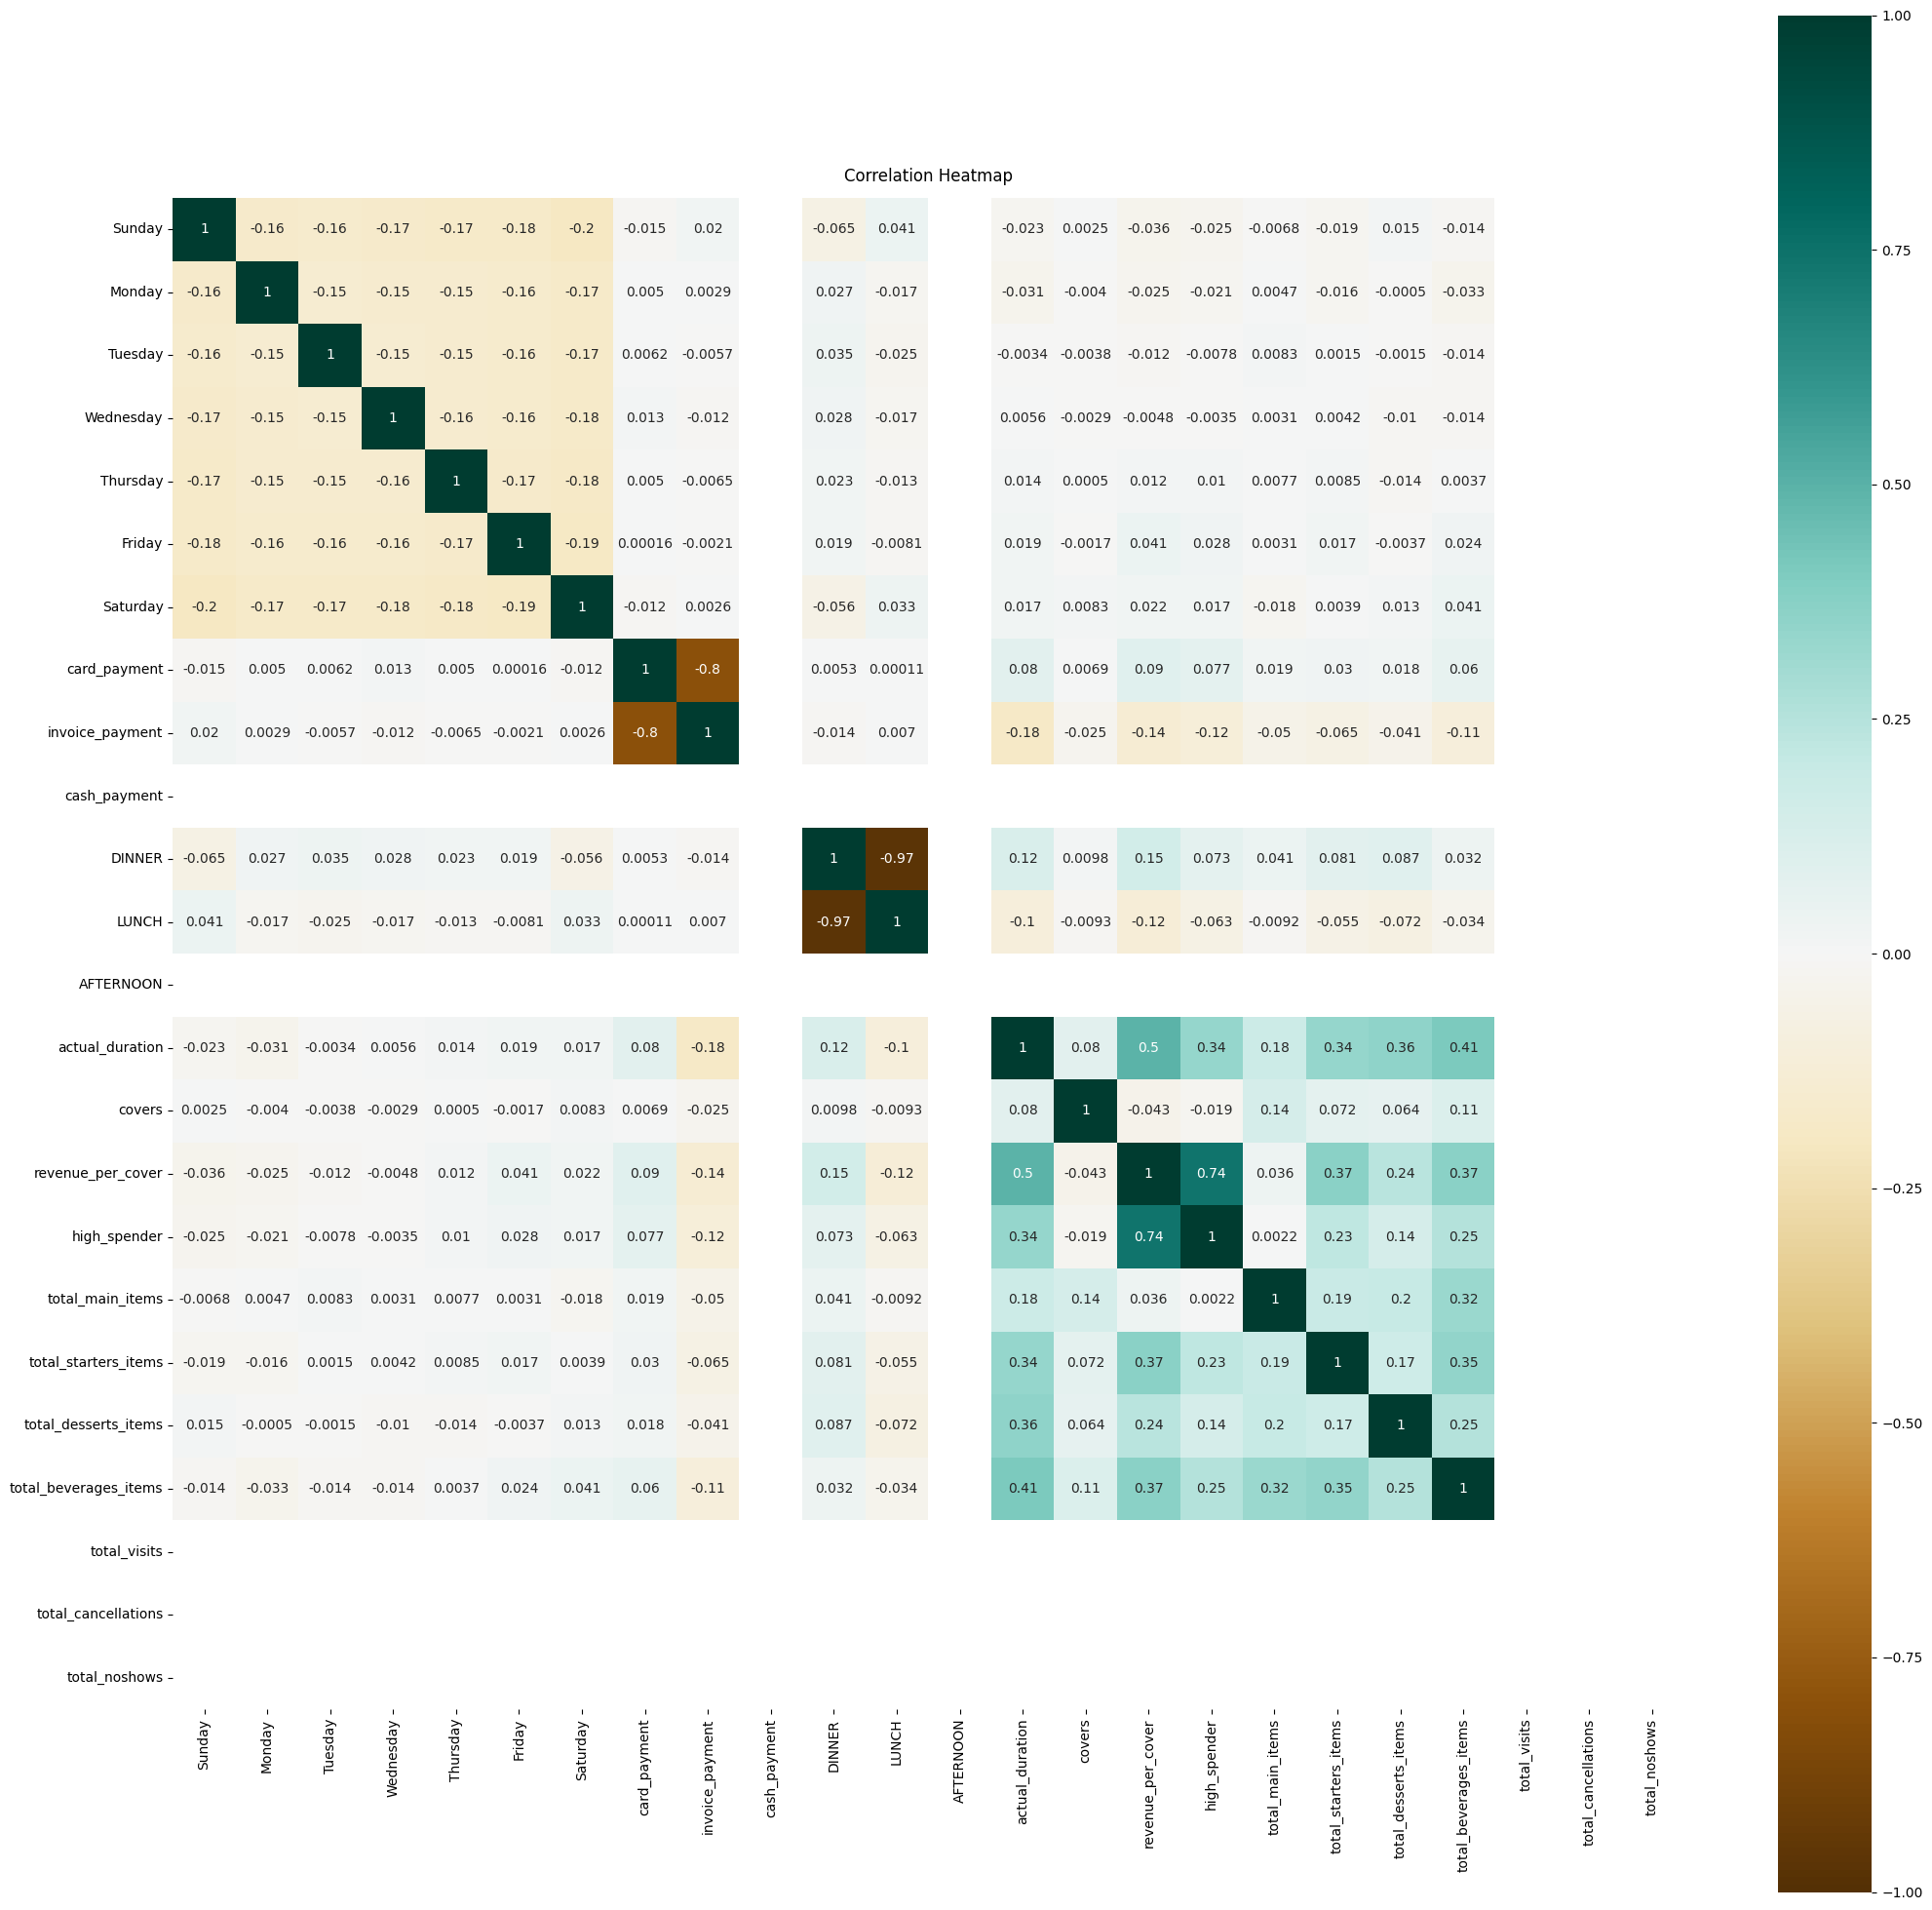

In [34]:
# Increase the size of the heatmap.
plt.figure(figsize=(25,25))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(ml.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

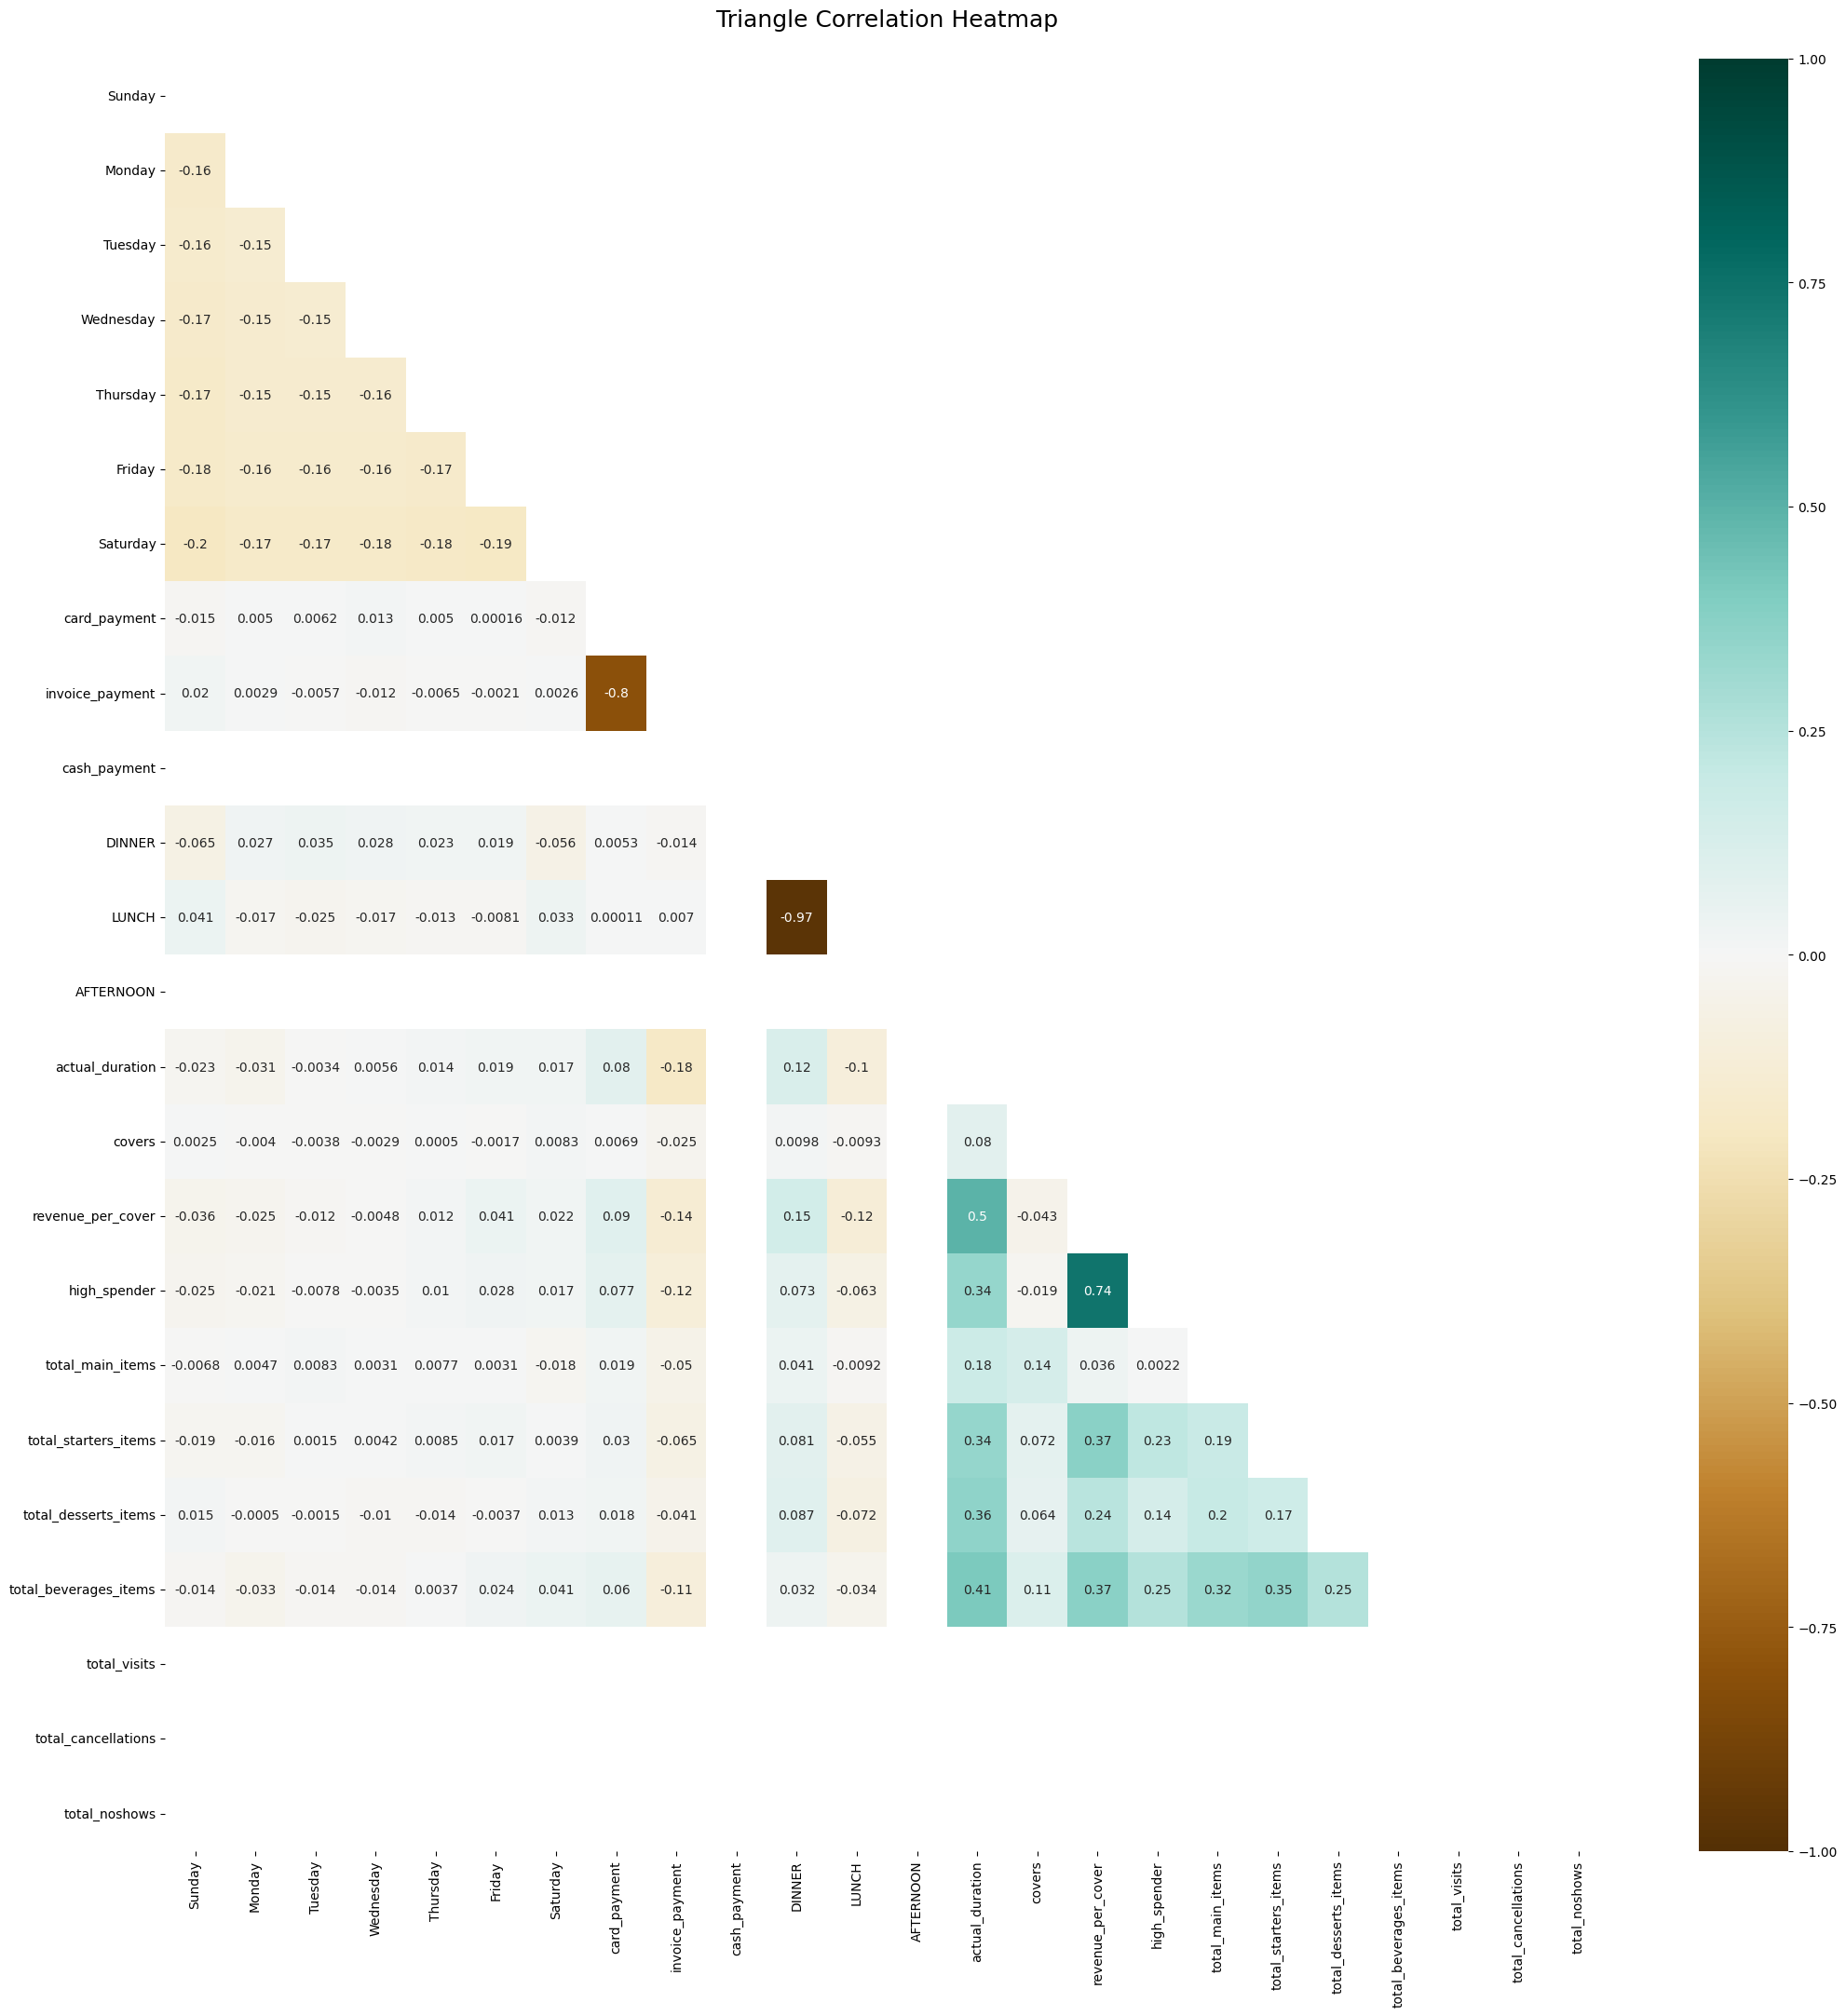

In [35]:
plt.figure(figsize=(25,25))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(ml.corr(), dtype=bool))
heatmap = sns.heatmap(ml.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=25)

#### Distribution check

In [36]:
ml_distribution = pd.DataFrame(ml.sum(axis=0))
ml_distribution.rename(columns={0:'count'},inplace=True)
ml_distribution['percent'] = round((ml_distribution['count']/len(ml))*100,2)
ml_distribution.sort_values(by='percent',ascending=True)

,count,percent
total_noshows,0.0,0.0
AFTERNOON,0.0,0.0
total_cancellations,0.0,0.0
cash_payment,0.0,0.0
Tuesday,72181.0,12.57
Monday,73729.0,12.84
Wednesday,75517.0,13.15
Thursday,79442.0,13.84
high_spender,81691.0,14.23
Friday,85230.0,14.84


#### Scaling features


In [37]:
#Scaling the ML table and storing the output 
#Initializing and training scaler 
scaler=StandardScaler()
ml_scaled=scaler.fit_transform(ml)

In [38]:
#Checking our scaled features 
ml_scaled_df=pd.DataFrame(ml_scaled,columns=scaler.get_feature_names_out())
ml_scaled_df

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
0,-0.429514,2.605388,-0.379183,-0.389142,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,0.565806,-0.481229,-0.407266,1.392042,1.177464,-0.747096,1.668972,0.0,0.0,0.0
1,-0.429514,-0.383820,2.637247,-0.389142,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,0.565806,0.459217,-0.407266,0.616710,3.436548,3.432317,2.516007,0.0,0.0,0.0
2,-0.429514,2.605388,-0.379183,-0.389142,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,-1.253539,-0.407266,-0.158622,-1.081621,-0.747096,-0.872133,0.0,0.0,0.0
3,-0.429514,2.605388,-0.379183,-0.389142,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,-0.433788,-0.407266,-0.933953,-0.328592,-0.747096,-0.448616,0.0,0.0,0.0
4,-0.429514,-0.383820,-0.379183,2.569757,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,-1.374932,-0.407266,-0.158622,-1.081621,-0.747096,-0.448616,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574200,-0.429514,-0.383820,-0.379183,2.569757,-0.400707,-0.417497,-0.455525,-0.438843,-1.818658,0.0,...,-0.186964,1.263620,2.455400,-0.158622,-0.328592,0.297757,1.668972,0.0,0.0,0.0
574201,-0.429514,-0.383820,-0.379183,2.569757,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,1.803609,2.455400,-0.158622,0.424436,1.342610,-0.025098,0.0,0.0,0.0
574202,-0.429514,-0.383820,-0.379183,2.569757,-0.400707,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,-0.384952,-0.407266,-0.933953,-0.328592,0.297757,-0.872133,0.0,0.0,0.0
574203,-0.429514,-0.383820,-0.379183,-0.389142,2.495592,-0.417497,-0.455525,-0.438843,0.549856,0.0,...,-0.186964,-0.116353,-0.407266,-0.158622,-0.328592,1.342610,-0.448616,0.0,0.0,0.0


# Elbow check to find the proper number of cluster 

#### Elbow method 

In [39]:
#Elbow method
inertias = []
n_k = range(1, 10)

# for each number of centroids
for k in n_k:
     kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(ml_scaled)
     inertias.append(kmeans.inertia_)
print(inertias )

[10909895.000000041, 9911986.595867079, 8979869.76919101, 8243741.838787441, 8128038.506373828, 7705799.514192159, 7131684.069069818, 6626101.733645299, 6191800.551005749]


In [40]:
#Plotting the inertias
import plotly.express as px 
fig = px.line(inertias)
fig.show()

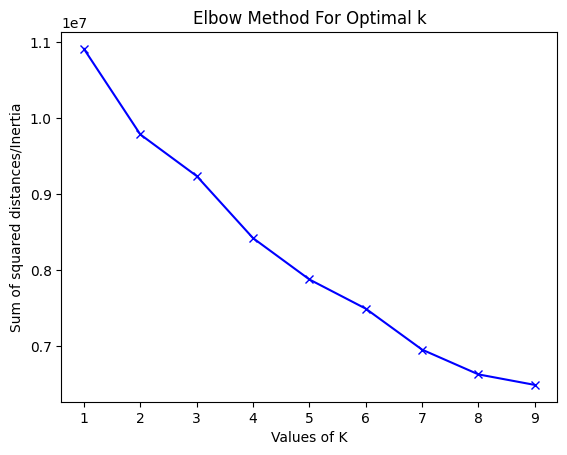

In [41]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters,n_init="auto")
 kmeans.fit(ml_scaled)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

#### Scoring the model via score Calinski-Harabasz Index and Davies-Bouldin Index

In [42]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

#Lauching clustering prediction
kmeans = KMeans(n_clusters=7, random_state=12, n_init="auto").fit(ml_scaled)
labels_scaled=kmeans.predict(ml_scaled)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(ml_scaled, labels_scaled)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(ml_scaled, labels_scaled)
print(f"Calinski-Harabasz Index: {ch_index}")

Davies-Bouldin Index: 1.8373461409586298
Calinski-Harabasz Index: 54204.23638731245


Davies-Bouldin Index (DBI):

The DBI measures the compactness and separation of clusters. A lower DBI indicates better clustering, where clusters are well-defined and separated.
The index is calculated based on the average similarity between each cluster and its most similar cluster, normalized by the average dissimilarity between the clusters.
A lower DBI is desirable, and the range of values is not bounded.
In your case, a DBI of 2.7177 is relatively good. It suggests that, on average, the clusters are compact and well-separated.

Calinski-Harabasz Index (CHI):

The CHI, also known as the Variance Ratio Criterion, measures the ratio of the between-cluster variance to the within-cluster variance. Higher values indicate better-defined and more separated clusters.
It considers both the distance between cluster centers (numerator) and the spread or dispersion of points within clusters (denominator).
A higher CHI is indicative of better clustering, and the range of values is not bounded.
In your case, a CHI of 52557.6397 is quite high, suggesting that the clusters are well-separated and distinct.

Interpretation:

The combination of a low DBI and a high CHI is generally favorable. It suggests that your clustering algorithm has produced clusters that are both compact and well-separated.

#### First clustering test 

labels
0     84375
1     79874
2     68935
3     63962
4    129552
5     75151
6     72356
Name: Sunday, dtype: Int64


<Axes: xlabel='labels', ylabel='count'>

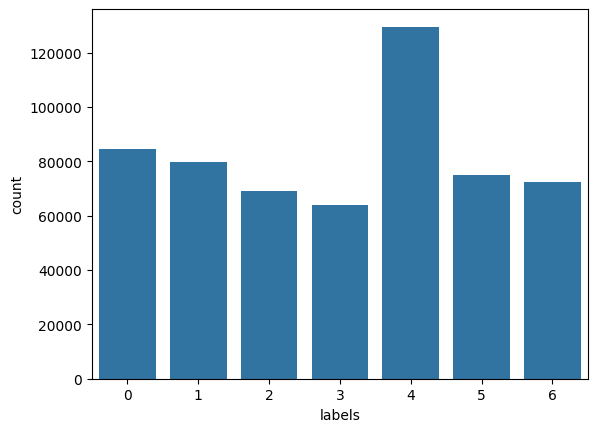

In [43]:

#Applying labels to the original dataframe
ml['labels']=labels_scaled
ml_scaled_df['labels']=labels_scaled
ml_distrib=ml.groupby('labels',as_index=True)['Sunday'].count()

#Printing number + graph to vizualize 
print(ml_distrib)
sns.countplot(ml,x='labels')

# Exploring results

##### Heatmap

In [44]:
# Analyzing Cluster Results
import matplotlib.pyplot as plt
import seaborn as sns

#Creating heatmap
cm = sns.light_palette("green", as_cmap=True)
#a remettre en ml au lieu de ml_scaled
ml.groupby('labels')[ml.columns[:-1]].mean().style.background_gradient(cmap=cm)

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,DINNER,LUNCH,AFTERNOON,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
labels,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.139496,0.793399,0.000000,0.519407,0.435070,0.000000,80.012113,2.841351,32.285487,0.013369,2.131520,1.301357,0.672320,2.988148,1.000000,0.000000,0.000000
1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135939,0.806558,0.000000,0.515299,0.439254,0.000000,78.412362,2.789619,31.403195,0.017515,2.161442,1.266182,0.693179,2.766845,1.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.151940,0.785972,0.000000,0.611301,0.387162,0.000000,79.630928,2.756510,32.286081,0.022354,2.212301,1.321767,0.621397,2.781287,1.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.153622,0.783934,0.000000,0.629639,0.369032,0.000000,79.046856,2.711860,31.888248,0.024108,2.220193,1.316360,0.653888,2.713799,1.000000,0.000000,0.000000
4,0.000000,0.499437,0.000000,0.500563,0.000000,0.000000,0.000000,0.156493,0.783863,0.000000,0.619535,0.379137,0.000000,78.142352,2.730301,31.379288,0.003358,2.209051,1.289374,0.645895,2.661557,1.000000,0.000000,0.000000
5,0.127184,0.120105,0.109366,0.141954,0.139812,0.171308,0.190270,0.249644,0.618927,0.000000,0.704462,0.293995,0.000000,113.661681,2.635175,62.561188,0.989315,2.310748,2.328592,1.122567,4.859416,1.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.148737,0.789831,0.000000,0.603295,0.395157,0.000000,79.727694,2.742938,32.771157,0.017939,2.198007,1.333393,0.632677,2.877591,1.000000,0.000000,0.000000


#### Scatter plot

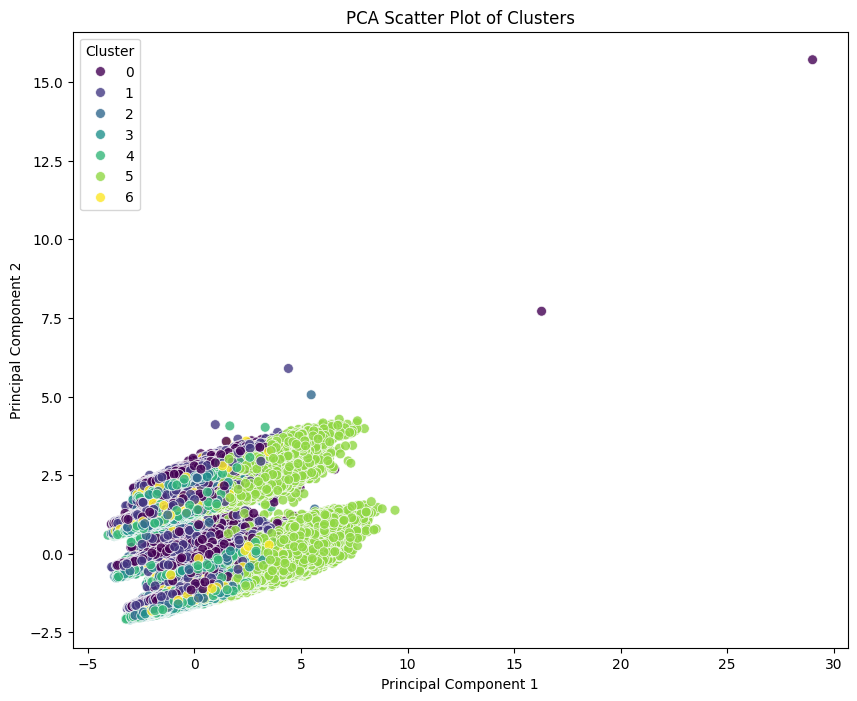

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming 'df' is your DataFrame with features and cluster labels
# 'features' are the columns containing your feature values
# 'cluster_column' is the column containing cluster labels (e.g., 'Cluster')

# Extract features and cluster labels
X = ml_scaled_df.drop('labels', axis=1)  
y = ml_scaled_df['labels']

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the reduced features and cluster labels
df_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Cluster'] = y

# Scatter plot using seaborn's hue parameter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='viridis', s=50, alpha=0.8, edgecolors='w')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Clusters')

# Show the plot
plt.show()


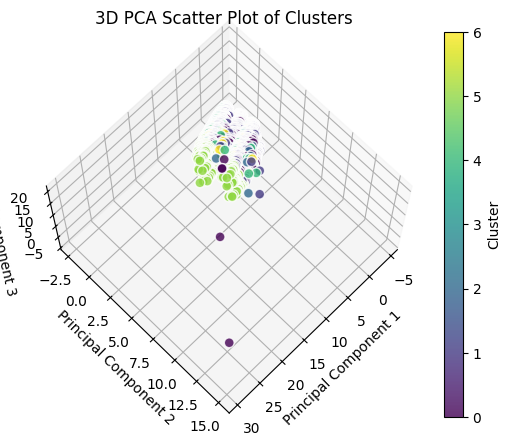

In [46]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'ml' is your DataFrame with features and cluster labels
# 'features' are the columns containing your feature values
# 'cluster_column' is the column containing cluster labels (e.g., 'Cluster')

# Extract features and cluster labels
X = ml_scaled_df.drop('labels', axis=1)  # Assuming 'labels' is the column with labels labels
y = ml_scaled_df['labels']

# Apply PCA to reduce dimensionality to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the reduced features and labels labels
ml_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
ml_pca['labels'] = y

# 3D Scatter plot using seaborn's hue parameter
plt.figure(figsize=(7, 5))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(ml_pca['Principal Component 1'], ml_pca['Principal Component 2'], ml_pca['Principal Component 3'], c=ml_pca['labels'], cmap='viridis', s=50, alpha=0.8, edgecolors='w')

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatter Plot of Clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

ax.view_init(elev=70, azim=45)

# Show the plot
plt.show()

In [47]:
# import plotly.express as px
# from sklearn.preprocessing import StandardScaler

# # Assuming 'ml_scaled_df' is your DataFrame with scaled features and labels
# # Assuming 'labels' is the column with cluster labels
# X = ml_scaled_df.drop('labels', axis=1)
# y = ml_scaled_df['labels']

# # Standard scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply PCA to reduce dimensionality to 3 components
# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_scaled)

# # Create a DataFrame with the reduced features and labels
# ml_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
# ml_pca['labels'] = y

# # Create an interactive scatter plot using plotly express
# fig = px.scatter_3d(ml_pca, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3', color='labels', size_max=10, opacity=0.8, title='Interactive PCA Scatter Plot of Clusters')

# # Update the layout for better hover information
# fig.update_layout(scene=dict(
#                     xaxis=dict(title='Principal Component 1'),
#                     yaxis=dict(title='Principal Component 2'),
#                     zaxis=dict(title='Principal Component 3')
#                 ),
#                 showlegend=True,
#                 scene_camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64)))

# # Show the interactive plot
# fig.write_html("interactive_plot.html")


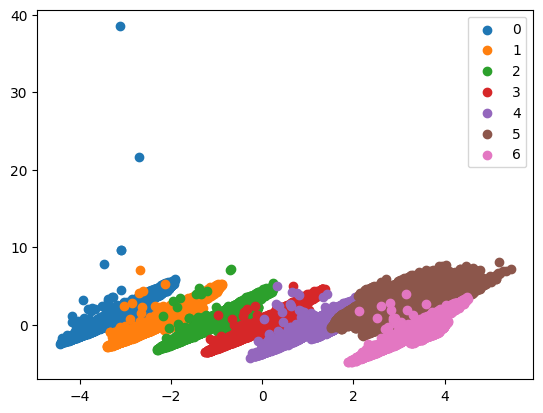

In [48]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

#Transform the data
pca = PCA(2)
ml_results= pca.fit_transform(ml_scaled_df)


#Getting unique labels
u_labels = np.unique(labels_scaled)
 
#plotting the results:
for i in u_labels:
    plt.scatter(ml_results[labels_scaled == i , 0] , ml_results[labels_scaled == i , 1] , label= i)
plt.legend()
plt.show()

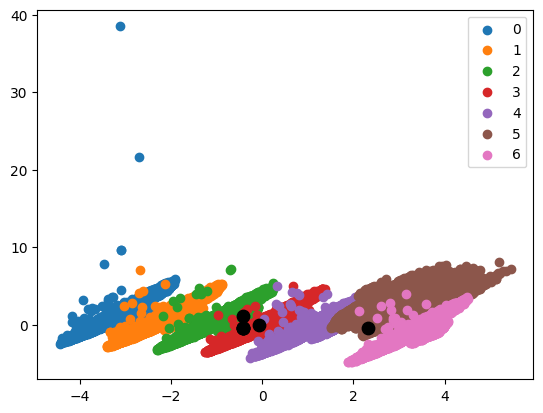

In [49]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels_scaled)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(ml_results[labels_scaled == i , 0] , ml_results[labels_scaled == i , 1] , label= i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [59]:

pd.options.display.max_columns = None
ml.describe(include='all')

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,DINNER,LUNCH,AFTERNOON,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows,labels
count,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.0,574205.000000,574205.0,574205.000000,574205.000000,574205.000000,574205.000000,574205.0,574205.0,574205.0,574205.000000
mean,0.155749,0.128402,0.125706,0.131516,0.138351,0.148431,0.171845,0.161484,0.767848,0.0,0.599528,0.386432,0.0,83.582602,2.745105,35.937756,0.142268,2.204585,1.436362,0.715025,3.059261,1.0,0.0,0.0,3.026322
std,0.362618,0.334537,0.331518,0.337964,0.345269,0.355527,0.377246,0.367977,0.422206,0.0,0.489994,0.486932,0.0,31.982939,3.985284,14.333633,0.349325,1.289772,1.327973,0.957073,2.361179,0.0,0.0,0.0,1.970150
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,60.0,2.0,25.880000,0.0,1.000000,0.000000,0.000000,1.000000,1.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,79.0,2.0,33.740000,0.0,2.000000,1.000000,0.000000,3.000000,1.0,0.0,0.0,3.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,102.0,3.0,43.250000,0.0,3.000000,2.000000,1.000000,4.000000,1.0,0.0,0.0,5.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,207.0,2000.0,109.750000,1.0,7.000000,6.000000,4.000000,13.000000,1.0,0.0,0.0,6.000000
